<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar 12: Neural Networks 1</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Data Generation

In [2]:
from sklearn.datasets import make_moons, make_circles # import function from the library

N = 1000

X, y = make_moons(n_samples=N, noise=0.1, random_state=11) # generate data sample
# X, y = make_circles(n_samples=N, noise=0.01, factor=0.6, random_state=1)

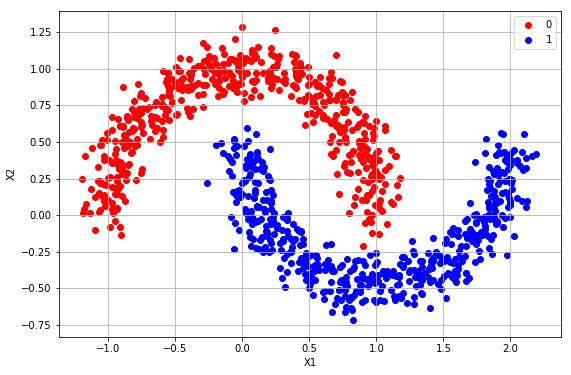

In [3]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X[y == 0, 0],     # selects all objects with y == 0 and the 1st column of X
            X[y == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='r',        # points color
            label='0')        # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X[y == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X[y == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='b',        # points color
            label='1')        # label for the plot legend

plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid(b=1) # create grid on the plot

plt.show() # display the plot

# Tarain / Test Split

In [4]:
def one_hot(a, num_classes):
    return np.eye(num_classes)[a.reshape(-1)]

In [5]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    
                                                    random_state=123) 

y_train_hot = one_hot(y_train, 2)
y_test_hot = one_hot(y_test, 2)

In [6]:
y_train[:5]

array([0, 0, 0, 1, 1])

In [7]:
y_train_hot[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

# Neural Network Implementation

<center><img src='img/nn.png'></center>

## Definitions

* Denote $w_{ij}$ as weight of edge, connecting $i$-th and $j$-th neuron
* Define $\delta_j = \frac{\partial L}{\partial I_j} =  \frac{\partial L}{\partial O_j}\frac{\partial O_j}{\partial I_j}$
* Since $L$ depends on $w_{ij}$ through the following functional relationship $L(w_{ij}) = L\left(O_j\left(I_j(w_{ij})\right)\right)$, using the chain rule we get:
$$ \frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial I_j}\frac{\partial I_j}{\partial w_{ij}} = \delta_j O_i$$
because $\frac{\partial I_j}{\partial w_{ij}} = \frac{\partial}{\partial w_{ij}} \left(\sum\limits_{k\in inc(j)} w_{kj} O_k\right) = O_i$, where $inc(j)$ is a set of neurons with outgoing edges to neuron $j$
* $\frac{\partial L}{\partial I_j} = \frac{\partial L}{\partial O_j}\frac{\partial O_j}{\partial I_j} = \frac{\partial L}{\partial O_j} f'(I_j) $

## Backprop Algorithm:

1. Forward propagate $x_n$ to the neural network, store all inputs $I_j$ and outputs $O_j$ for each neuron
2. Calculate $\delta_i$ for all $i \in$ output layer using:

$$ \delta_j= \frac{\partial L}{\partial O_j}\frac{\partial O_j}{\partial I_j} = \frac{\partial L}{\partial O_j} f'(I_j) \qquad (1)$$


3. Propagate $\delta_i$ from final layer back layer by layer:

$$ \delta_j = \frac{\partial L}{\partial I_j} =  \frac{\partial L}{\partial O_j}\frac{\partial O_j}{\partial I_j} = \sum\limits_{k\in out(j)} \left(\delta_k w_{jk}\right) f'(I_j) \qquad (2)$$


4. Using calculated deltas and outputs calculate $\frac{\partial L}{\partial w_{ij}}$ with:


$$ \frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial I_j}\frac{\partial I_j}{\partial w_{ij}} = \delta_jO_j \qquad (3)$$

More details in this [notebook](https://github.com/shestakoff/hse_se_ml/blob/master/2018/seminar-nn1/seminar-nn1-proc.ipynb
).

## Example

Consider a neural network with 1 input layer, 1 hidden layer and 1 output layer with ReLU activation function. The network output values will be calculated uwing SoftMax function:


$$z_l = \frac{\exp(net_l)}{\sum_l \exp(net_l)}$$

So, the network have to return probabilities for each class.

We will use cross-entropy loss function:
$$L(\hat{y}(t)) = - \sum\limits_{c \in classes} y_c\log(\hat{y}_c)$$


Total error is calculated with regularization:
$$L = \frac{1}{N}\sum\limits_{t=1}^N L(\hat{y}(t)) + \lambda\frac{1}{2}\|\mathbf{W}\|^2$$

In [8]:
class MyNN(object):
    
    def __init__(self, n_input, n_hidden, n_output, learning_rate=0.01, C=0.01, n_iters=100):
        
        # Initialize number of neurons in each layer
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        self.learning_rate = learning_rate
        self.C = C
        self.n_iters = n_iters
        
        # Initialize weigths of the network
        self.W1 = 0.01 * np.random.randn(self.n_input, self.n_hidden) 
        self.b1 = np.zeros((1, self.n_hidden))

        self.W2 = 0.01 * np.random.randn(self.n_hidden, self.n_output) 
        self.b2 = np.zeros((1, self.n_output))
        
        
    def activation(self, Z):
        return np.maximum(0, Z)
    
    def softmax(self, A):
        probs = np.exp(A)/np.exp(A).sum(axis=1, keepdims=True)
        return probs
        
        
    def forward(self, X):
        
        # The first layer of the NN
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self.activation(Z1)
        
        # The second layer of the NN
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.activation(Z2)
        
        # The NN output values (predictied y)
        y_hat = self.softmax(A2)
        
        return Z1, A1, Z2, A2, y_hat
    
    
    def backpropagation(self, X, y, Z1, A1, Z2, A2, y_hat):
        
        dy = y_hat - y
        
        dW2 = np.dot(A1.T, dy) + self.C * self.W2 # regularization 
        db2 = np.sum(dy, axis=0, keepdims=True)
        
        dA1 = np.dot(dy, self.W2.T)
        dA1[A1 <= 0] = 0
        
        dW1 = np.dot(X.T, dA1) + self.C * self.W1
        db1 = np.sum(dA1, axis=0, keepdims=True)
        
        
        # Update weights
        self.W1 = self.W1 - self.learning_rate * dW1
        self.b1 = self.b1 - self.learning_rate * db1
        
        self.W2 = self.W2 - self.learning_rate * dW2
        self.b2 = self.b2 - self.learning_rate * db2
        
        
    def fit(self, X, y):
        for i in range(self.n_iters):
            Z1, A1, Z2, A2, y_hat = self.forward(X)
            self.backpropagation(X, y, Z1, A1, Z2, A2, y_hat)
            
    
    def predict_proba(self, X):
        Z1, A1, Z2, A2, y_hat = self.forward(X)
        return y_hat
    
    
    def predict(self, X):
        y_hat = self.predict_proba(X)
        labels = y_hat.argmax(axis=1)
        return labels

In [9]:
nn = MyNN(n_input=2, n_hidden=5, n_output=2, learning_rate=0.01, C=0.01, n_iters=10000)
nn.fit(X_train, y_train_hot)
y_test_hat = nn.predict_proba(X_test)

In [10]:
def plot_decision_boundary(clf, X_test, y_test):

    # Plot all objects with y == 0 (class 0)
    plt.scatter(X_test[y_test == 0, 0],     # selects all objects with y == 0 and the 1st column of X
                X_test[y_test == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
                color='r',                  # points color
                label='0')                  # label for the plot legend


    # Plot all objects with y == 1 (class 1)
    plt.scatter(X_test[y_test == 1, 0],     # selects all objects with y == 1 and the 1st column of X
                X_test[y_test == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
                color='b',                  # points color
                label='1')                  # label for the plot legend


    ### THIS IS JUST MAGIC :)

    # plot decision boundary
    h=0.1
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6, levels=1)
    
    #Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    #Z = Z.reshape(xx.shape)
    #plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6, levels=5)
    #plt.colorbar()

    ### THE END OF THE MAGIC


    plt.xlabel('X1') # set up X-axis label
    plt.ylabel('X2') # set up Y-axis label

    plt.legend(loc='best') # create the plot legend and set up it position
    plt.grid(b=1) # create grid on the plot

Text(0.5, 1.0, 'NN')

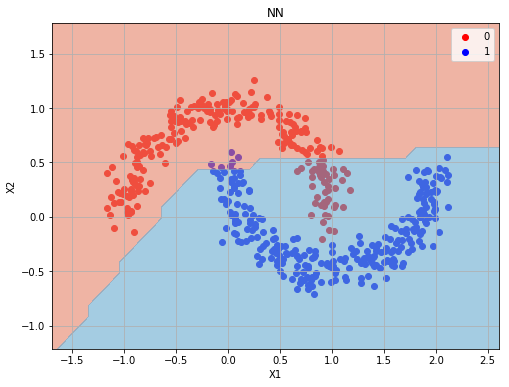

In [11]:
plt.figure(figsize=(8, 6))
plot_decision_boundary(nn, X_test, y_test)
plt.title('NN')

# NN in Keras

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Read Data

We use the data set [Pima Indians](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data) with the following features:


1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)


In [13]:
df = pd.read_csv('data/diabetes.csv',
                 sep=',')

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Train / Test Split

In [15]:
X, y = df.iloc[:, :8].values, df.iloc[:, 8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=11)

In [16]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

In [17]:
X_train_norm = standard_scaler.fit_transform(X_train)

# Create NN model

In [18]:
X.shape

(768, 8)

In [19]:
inputs = keras.Input(shape=(X.shape[1],) )

dense_first = layers.Dense(12, activation='sigmoid',
                           kernel_initializer=initializers.RandomNormal(),
                           bias_initializer=initializers.Zeros())
first_layer_outputs = dense_first(inputs)

## Dropout

Dropout is a kind of regularization in neural networks. Use them to avoid overfitting. In dropout we remove connection from our net with the specified probability. That probability call a dropout rate

<center><img src='img/dropout.png'></center>

In [20]:
#Let's apply a droput layer
dropout_layear = layers.Dropout(rate=0.01, seed=42)
first_layer_outputs = dropout_layear(first_layer_outputs)

In [21]:
dense_second = layers.Dense(8, activation='sigmoid',
                           kernel_initializer=initializers.RandomNormal(),
                           bias_initializer=initializers.Zeros())
second_layer_outputs = dense_second(first_layer_outputs)

dense_third = layers.Dense(1, activation='sigmoid',
                           kernel_initializer=initializers.RandomNormal(),
                           bias_initializer=initializers.Zeros())
outputs = dense_third(second_layer_outputs)

In [22]:
inputs.shape, outputs.shape

(TensorShape([None, 8]), TensorShape([None, 1]))

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="first_keras_model")
model.summary()

Model: "first_keras_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


Now we need to define [error function](https://keras.io/objectives/), [optimizer](https://keras.io/optimizers/) and [quality metric](https://keras.io/metrics/):

In [24]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], )

## Fit NN

In [25]:
X_train.shape

(614, 8)

In [26]:
# Fit the model
model.fit(X_train_norm, y_train, nb_epoch=150, batch_size=10, validation_split=0.2)

Train on 491 samples, validate on 123 samples
Epoch 1/150
491/491 [==============================] - 0s 915us/sample - loss: 0.6774 - accuracy: 0.6660 - val_loss: 0.6858 - val_accuracy: 0.5610
Epoch 2/150
491/491 [==============================] - 0s 98us/sample - loss: 0.6525 - accuracy: 0.6741 - val_loss: 0.6865 - val_accuracy: 0.5610
Epoch 3/150
491/491 [==============================] - 0s 89us/sample - loss: 0.6376 - accuracy: 0.6741 - val_loss: 0.6922 - val_accuracy: 0.5610
Epoch 4/150
491/491 [==============================] - 0s 89us/sample - loss: 0.6289 - accuracy: 0.6741 - val_loss: 0.6976 - val_accuracy: 0.5610
Epoch 5/150
491/491 [==============================] - 0s 95us/sample - loss: 0.6237 - accuracy: 0.6741 - val_loss: 0.7026 - val_accuracy: 0.5610
Epoch 6/150
491/491 [==============================] - 0s 99us/sample - loss: 0.6210 - accuracy: 0.6741 - val_loss: 0.7041 - val_accuracy: 0.5610
Epoch 7/150
491/491 [==============================] - 0s 101us/sample - loss

Epoch 56/150
491/491 [==============================] - 0s 92us/sample - loss: 0.5095 - accuracy: 0.7312 - val_loss: 0.5737 - val_accuracy: 0.6748
Epoch 57/150
491/491 [==============================] - 0s 94us/sample - loss: 0.5081 - accuracy: 0.7352 - val_loss: 0.5715 - val_accuracy: 0.6911
Epoch 58/150
491/491 [==============================] - 0s 92us/sample - loss: 0.5063 - accuracy: 0.7637 - val_loss: 0.5676 - val_accuracy: 0.6992
Epoch 59/150
491/491 [==============================] - 0s 92us/sample - loss: 0.5045 - accuracy: 0.7597 - val_loss: 0.5678 - val_accuracy: 0.6992
Epoch 60/150
491/491 [==============================] - 0s 91us/sample - loss: 0.5037 - accuracy: 0.7800 - val_loss: 0.5615 - val_accuracy: 0.7154
Epoch 61/150
491/491 [==============================] - 0s 90us/sample - loss: 0.5030 - accuracy: 0.7984 - val_loss: 0.5605 - val_accuracy: 0.7073
Epoch 62/150
491/491 [==============================] - 0s 91us/sample - loss: 0.5015 - accuracy: 0.8024 - val_loss: 0

491/491 [==============================] - 0s 90us/sample - loss: 0.4772 - accuracy: 0.7821 - val_loss: 0.5060 - val_accuracy: 0.7967
Epoch 112/150
491/491 [==============================] - 0s 91us/sample - loss: 0.4757 - accuracy: 0.7821 - val_loss: 0.5078 - val_accuracy: 0.7967
Epoch 113/150
491/491 [==============================] - 0s 91us/sample - loss: 0.4768 - accuracy: 0.7841 - val_loss: 0.5084 - val_accuracy: 0.7967
Epoch 114/150
491/491 [==============================] - 0s 92us/sample - loss: 0.4770 - accuracy: 0.7821 - val_loss: 0.5058 - val_accuracy: 0.7967
Epoch 115/150
491/491 [==============================] - 0s 93us/sample - loss: 0.4764 - accuracy: 0.7841 - val_loss: 0.5056 - val_accuracy: 0.7967
Epoch 116/150
491/491 [==============================] - 0s 90us/sample - loss: 0.4770 - accuracy: 0.7821 - val_loss: 0.5062 - val_accuracy: 0.7967
Epoch 117/150
491/491 [==============================] - 0s 90us/sample - loss: 0.4753 - accuracy: 0.7841 - val_loss: 0.5046 -

## Test NN

In [27]:
X_test_norm = standard_scaler.transform(X_test)
scores = model.evaluate(X_test_norm, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

154/154 [==============================] - 0s 33us/sample - loss: 0.5033 - accuracy: 0.7532

accuracy: 75.32%


In [28]:
y_hat = model.predict(X_test_norm).flatten()